# EDA - Keyphrase Extraction Dataset

Dataset from: https://github.com/snkim/AutomaticKeyphraseExtraction/
Using the Hulth2003 dataset with 1000+ scientific paper abstracts and keywords.


In [130]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


## Load Data


In [ ]:
# Load dataset
data_dir = Path('Hulth2003')

data = []
abstr_files = list(data_dir.glob('*.abstr'))

for abstr_file in abstr_files:
    doc_id = abstr_file.stem
    
    # Read abstract
    with open(abstr_file, 'r', encoding='utf-8', errors='ignore') as f:
        abstract = f.read().strip()
    
    # Read controlled keywords
    contr_file = data_dir / f"{doc_id}.contr"
    controlled = ""
    if contr_file.exists():
        with open(contr_file, 'r', encoding='utf-8', errors='ignore') as f:
            controlled = f.read().strip()
    
    # Read uncontrolled keywords
    uncontr_file = data_dir / f"{doc_id}.uncontr"
    uncontrolled = ""
    if uncontr_file.exists():
        with open(uncontr_file, 'r', encoding='utf-8', errors='ignore') as f:
            uncontrolled = f.read().strip()
    
    data.append({
        'doc_id': doc_id,
        'abstract': abstract,
        'controlled_keywords': controlled,
        'uncontrolled_keywords': uncontrolled
    })

df = pd.DataFrame(data)
print(f"Loaded {len(df)} documents")
df.head()


Loaded 1000 documents


,doc_id,abstract,controlled_keywords,uncontrolled_keywords
0,761,Towards a NMR implementation of a quantum latt...,computational fluid dynamics; diffusion; latti...,NMR implementation; quantum lattice gas algori...
1,724,Banking on SMA funds [separately managed accou...,banking; investment; outsourcing,separately managed accounts; investment manage...
2,1371,Design methodology for diagnostic strategies f...,industrial control; software maintenance; syst...,design methodology; modularity; local diagnost...
3,1334,A shy invariant of graphs\nMoving from a well ...,computational geometry; graph theory,graph invariant; induced odd cycles; minimum c...
4,1419,PacketVideo. One step ahead of the streaming w...,multimedia communication; notebook computers; ...,PacketVideo; multimedia content streaming; wir...


In [132]:
# Display basic information about the dataset
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


Dataset Info:
Shape: (1000, 4)

First few rows:


,doc_id,abstract,controlled_keywords,uncontrolled_keywords
0,761,Towards a NMR implementation of a quantum latt...,computational fluid dynamics; diffusion; latti...,NMR implementation; quantum lattice gas algori...
1,724,Banking on SMA funds [separately managed accou...,banking; investment; outsourcing,separately managed accounts; investment manage...
2,1371,Design methodology for diagnostic strategies f...,industrial control; software maintenance; syst...,design methodology; modularity; local diagnost...
3,1334,A shy invariant of graphs\nMoving from a well ...,computational geometry; graph theory,graph invariant; induced odd cycles; minimum c...
4,1419,PacketVideo. One step ahead of the streaming w...,multimedia communication; notebook computers; ...,PacketVideo; multimedia content streaming; wir...


In [133]:
# Create features
df_features = df.copy()

df_features['abstract_length'] = df_features['abstract'].str.len()
df_features['abstract_word_count'] = df_features['abstract'].str.split().str.len()
df_features['sentence_count'] = df_features['abstract'].str.count(r'[.!?]+')

df_features['uncontrolled_keyword_list'] = df_features['uncontrolled_keywords'].apply(
    lambda x: [kw.strip() for kw in x.split(';') if kw.strip()] if x and x.strip() else []
)
df_features['uncontrolled_keyword_count'] = df_features['uncontrolled_keyword_list'].str.len()

df_features['has_controlled_keywords'] = df_features['controlled_keywords'].apply(
    lambda x: True if x and x.strip() else False
)
df_features['has_uncontrolled_keywords'] = df_features['uncontrolled_keyword_count'] > 0

df_features['keyword_density'] = df_features['uncontrolled_keyword_count'] / df_features['abstract_word_count']

print(f"Shape: {df_features.shape}")


Shape: (1000, 12)


## 1. One-Dimensional Analysis - Histograms and Bar Charts
Following NIST EDA guidelines, we'll create histograms for numerical variables and bar charts for categorical variables.


Numerical columns (5): ['abstract_length', 'abstract_word_count', 'sentence_count', 'uncontrolled_keyword_count', 'keyword_density']
Categorical columns (7): ['doc_id', 'abstract', 'controlled_keywords', 'uncontrolled_keywords', 'uncontrolled_keyword_list', 'has_controlled_keywords', 'has_uncontrolled_keywords']


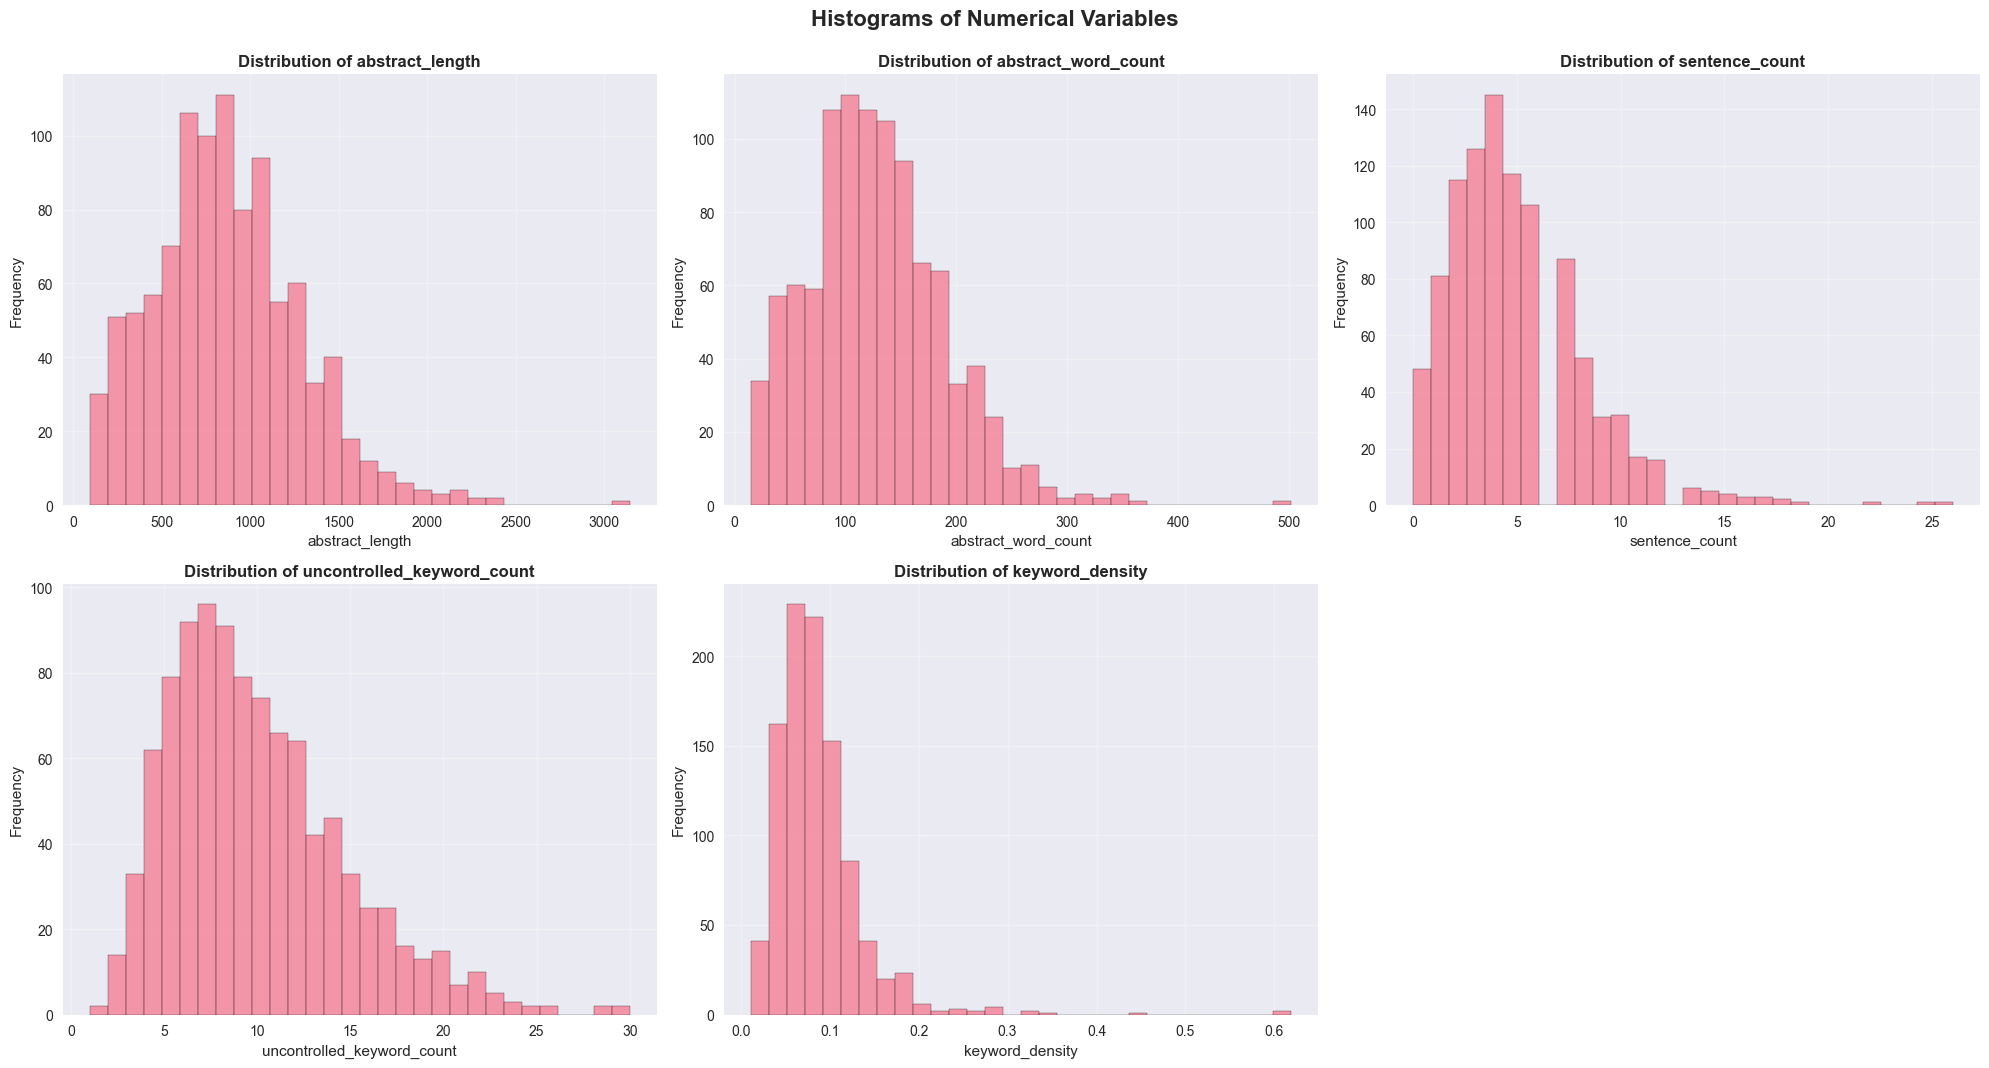

In [134]:
# Identify numerical and categorical columns
numerical_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_features.select_dtypes(include=['object', 'bool']).columns.tolist()

print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")

# Create histograms for numerical variables
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.ravel()

for i, col in enumerate(numerical_cols[:9]):  # Show first 9 numerical columns
    if i < len(axes):
        axes[i].hist(df_features[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)

# Hide unused subplots
for i in range(len(numerical_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('Histograms of Numerical Variables', fontsize=16, fontweight='bold', y=1.02)
plt.show()


## 2. Box Plots - All Variables Side by Side
Create box plots to visualize distributions and identify outliers.


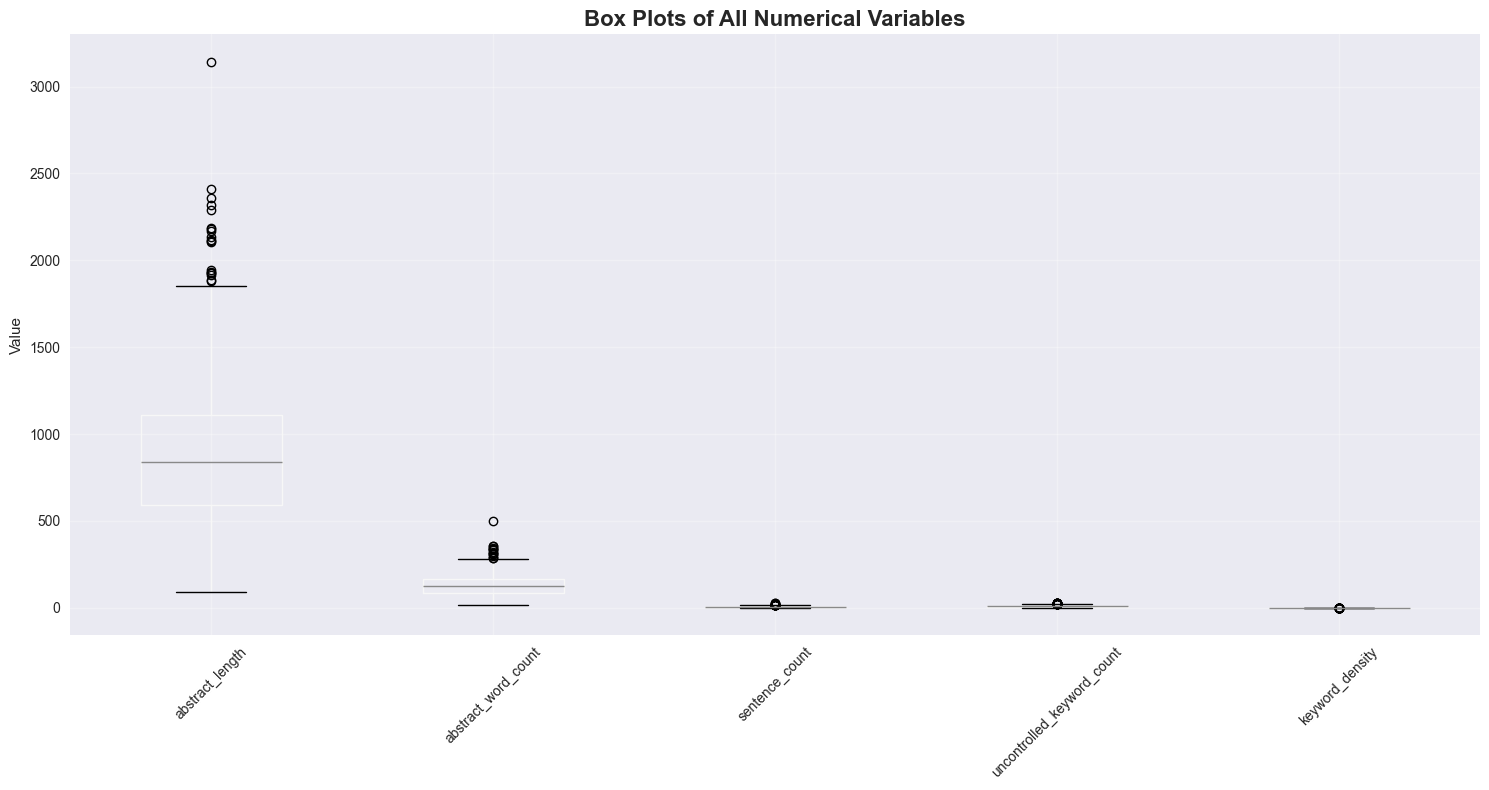

In [135]:
# Create a comprehensive box plot for all numerical variables
plt.figure(figsize=(15, 8))
df_features[numerical_cols].boxplot(rot=45)
plt.title('Box Plots of All Numerical Variables', fontsize=16, fontweight='bold')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Statistical Summary
Report max, min, mean, median, and outliers for each variable.


In [136]:
# Statistical summary for numerical variables
print("Statistical Summary of Numerical Variables:")
print("=" * 60)

for col in numerical_cols:
    data = df_features[col].dropna()
    if len(data) > 0:
        print(f"\n{col}:")
        print(f"  Count: {len(data)}")
        print(f"  Mean: {data.mean():.2f}")
        print(f"  Median: {data.median():.2f}")
        print(f"  Min: {data.min():.2f}")
        print(f"  Max: {data.max():.2f}")
        print(f"  Std: {data.std():.2f}")
        
        # Calculate outliers using IQR method
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        print(f"  Outliers: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)")
        if len(outliers) > 0:
            print(f"  Outlier values: {outliers.tolist()[:10]}{'...' if len(outliers) > 10 else ''}")


Statistical Summary of Numerical Variables:

abstract_length:
  Count: 1000
  Mean: 869.54
  Median: 839.00
  Min: 93.00
  Max: 3144.00
  Std: 415.59
  Outliers: 19 (1.9%)
  Outlier values: [3144, 1933, 2134, 2189, 2361, 2409, 1881, 1930, 2320, 1918]...

abstract_word_count:
  Count: 1000
  Mean: 128.10
  Median: 124.00
  Min: 15.00
  Max: 502.00
  Std: 61.50
  Outliers: 14 (1.4%)
  Outlier values: [502, 307, 344, 339, 356, 355, 308, 335, 297, 320]...

sentence_count:
  Count: 1000
  Mean: 4.93
  Median: 4.00
  Min: 0.00
  Max: 26.00
  Std: 3.38
  Outliers: 21 (2.1%)
  Outlier values: [25, 16, 16, 17, 14, 18, 16, 15, 14, 15]...

uncontrolled_keyword_count:
  Count: 1000
  Mean: 9.79
  Median: 9.00
  Min: 1.00
  Max: 30.00
  Std: 4.88
  Outliers: 26 (2.6%)
  Outlier values: [23, 24, 23, 29, 22, 24, 22, 22, 22, 24]...

keyword_density:
  Count: 1000
  Mean: 0.09
  Median: 0.08
  Min: 0.01
  Max: 0.62
  Std: 0.05
  Outliers: 37 (3.7%)
  Outlier values: [0.1875, 0.2, 0.18181818181818182, 0

## 4. Scatter Plot Matrix


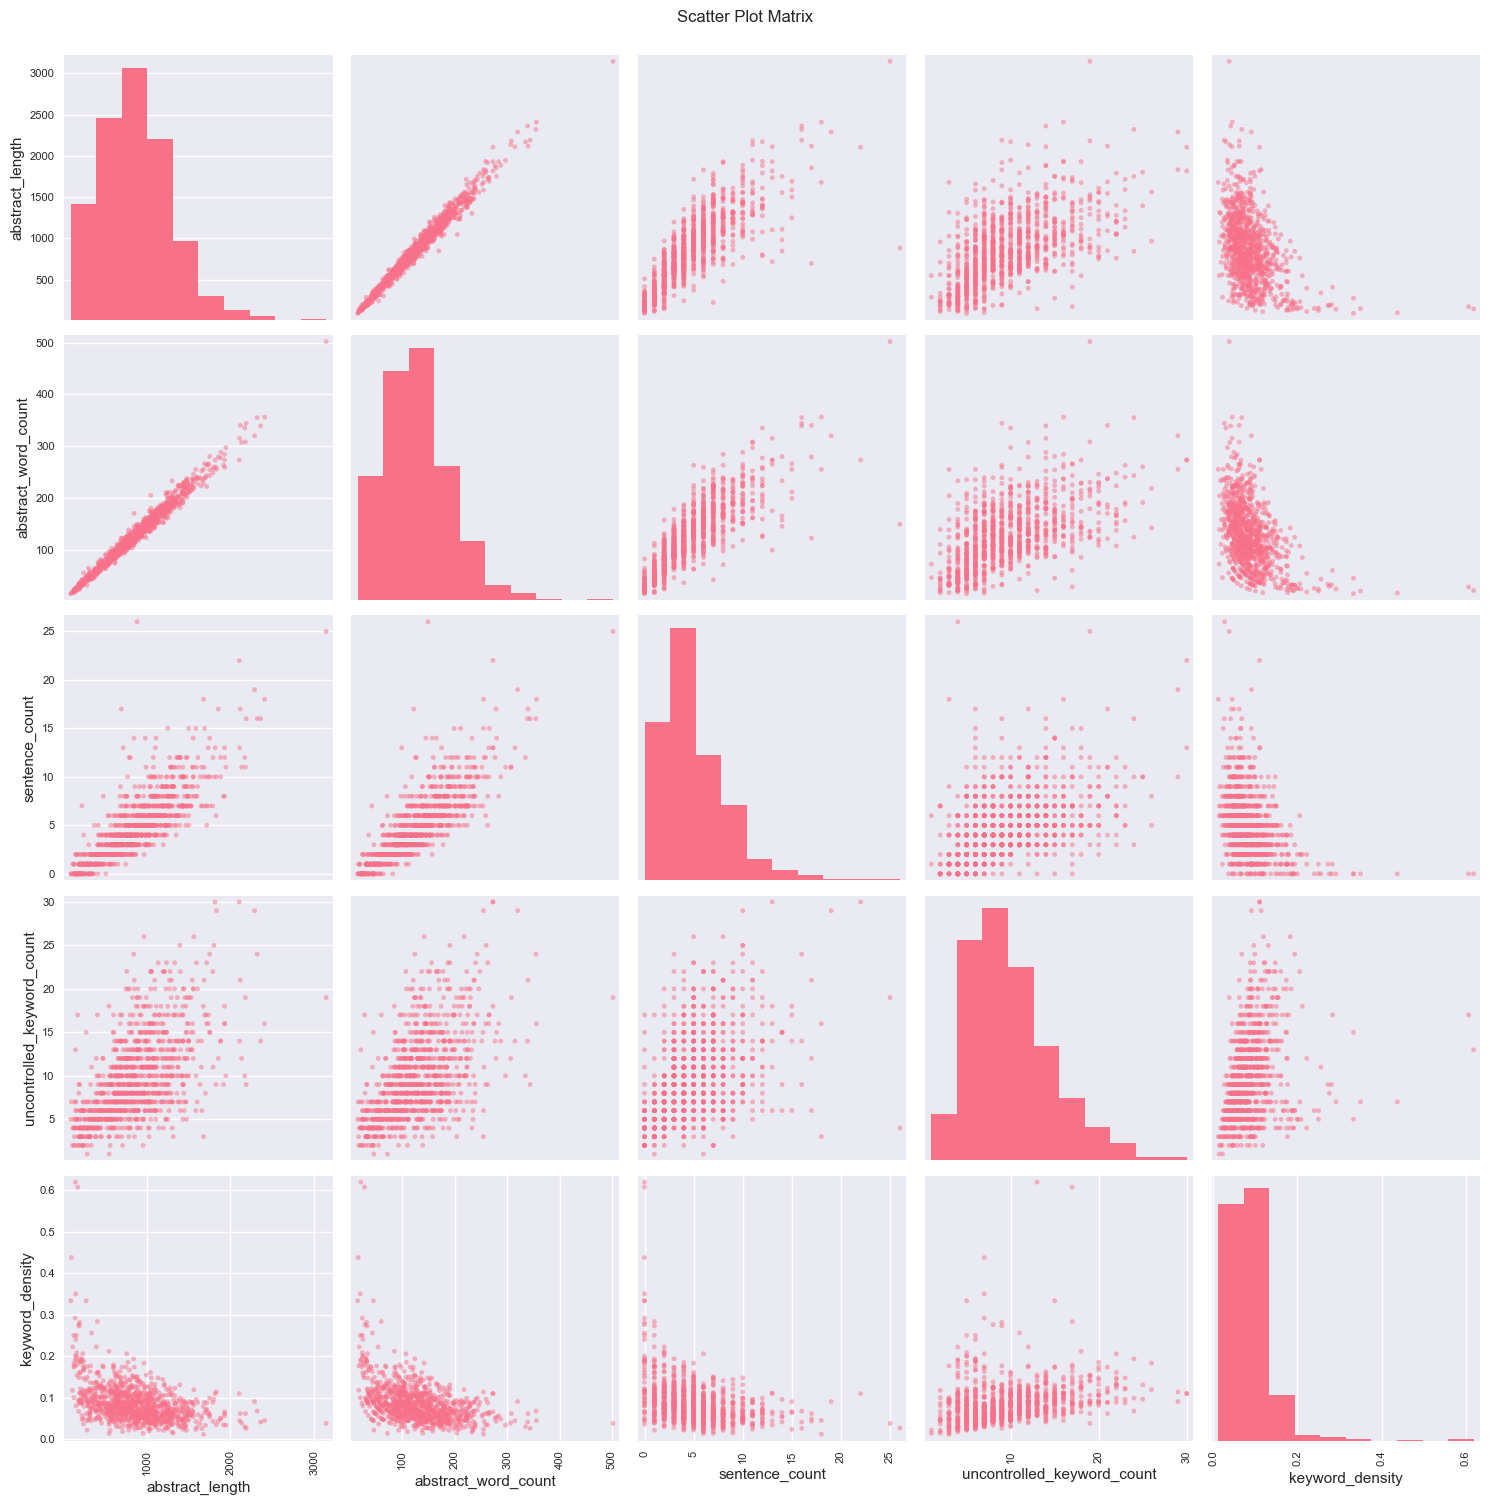

In [137]:
# Scatter plot matrix for numerical variables
from pandas.plotting import scatter_matrix

scatter_matrix(df_features[numerical_cols], figsize=(15, 15), diagonal='hist')
plt.suptitle('Scatter Plot Matrix', y=1.0)
plt.tight_layout()
plt.show()


## 5. Categorical vs Categorical



Cross-tabulation: has_controlled_keywords vs has_uncontrolled_keywords
has_uncontrolled_keywords  True   All
has_controlled_keywords              
True                       1000  1000
All                        1000  1000


<Figure size 800x600 with 0 Axes>

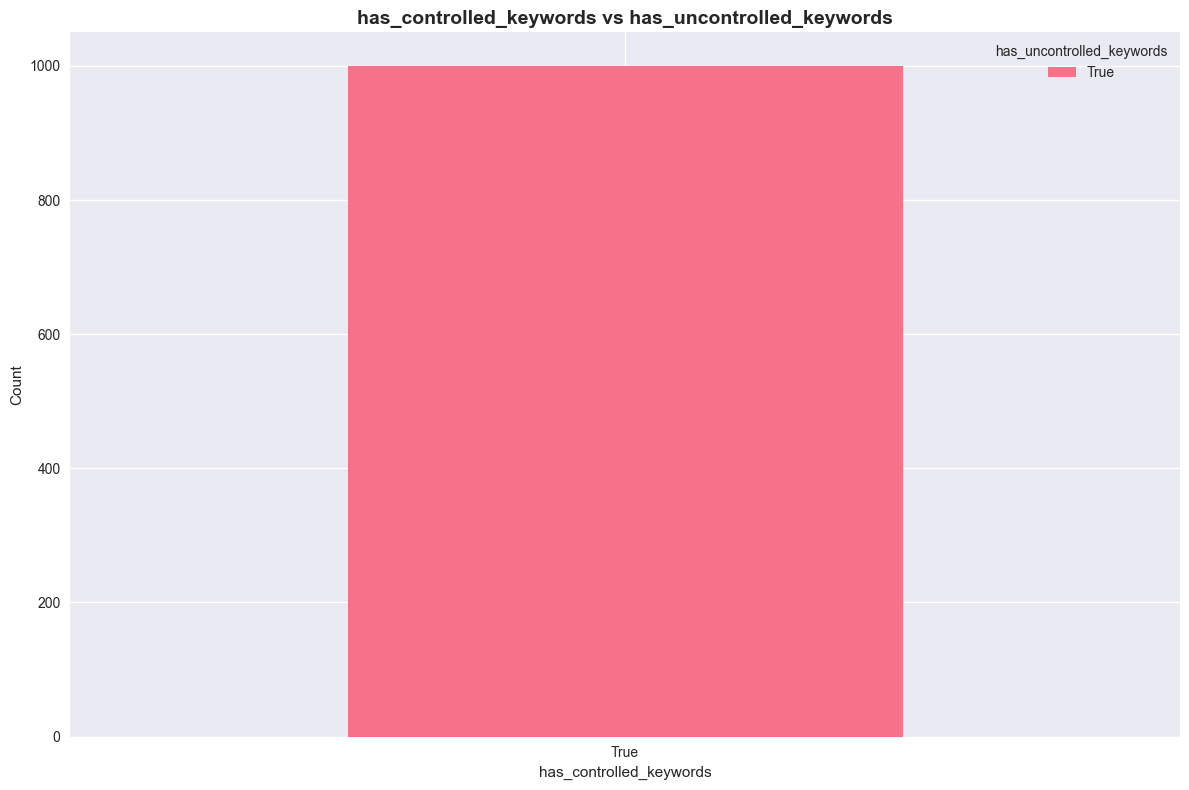


Percentage distribution:
has_uncontrolled_keywords   True
has_controlled_keywords         
True                       100.0


In [138]:
# Analyze categorical relationships
categorical_pairs = [('has_controlled_keywords', 'has_uncontrolled_keywords')]

for cat1, cat2 in categorical_pairs:
    if cat1 in df_features.columns and cat2 in df_features.columns:
        print(f"\nCross-tabulation: {cat1} vs {cat2}")
        print("=" * 50)
        
        # Create cross-tabulation
        crosstab = pd.crosstab(df_features[cat1], df_features[cat2], margins=True)
        print(crosstab)
        
        # Create visualization
        plt.figure(figsize=(8, 6))
        crosstab_plot = pd.crosstab(df_features[cat1], df_features[cat2])
        crosstab_plot.plot(kind='bar', stacked=True)
        plt.title(f'{cat1} vs {cat2}', fontsize=14, fontweight='bold')
        plt.xlabel(cat1)
        plt.ylabel('Count')
        plt.legend(title=cat2)
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Calculate percentages
        print(f"\nPercentage distribution:")
        crosstab_pct = pd.crosstab(df_features[cat1], df_features[cat2], normalize='index') * 100
        print(crosstab_pct.round(2))


## 6. Categorical vs Numerical (Color Coded)



Analysis of has_controlled_keywords vs Numerical Variables


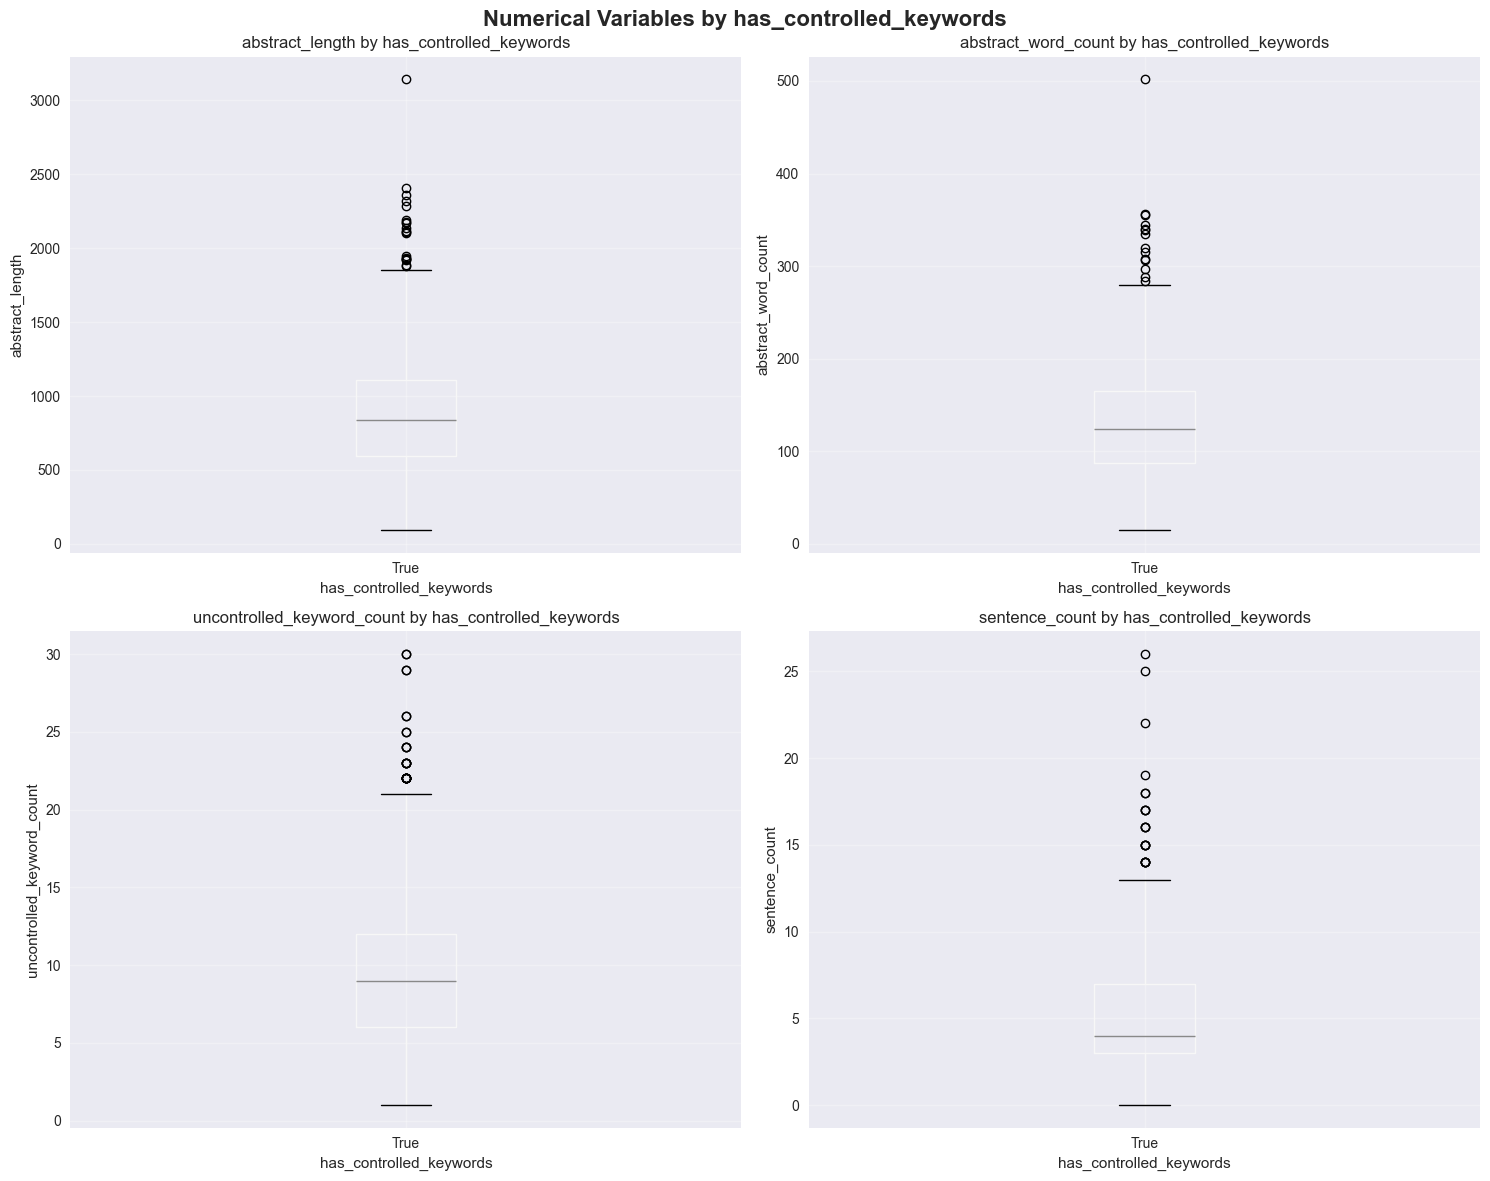


Statistical summary by has_controlled_keywords:

abstract_length:
                         count    mean  median     std
has_controlled_keywords                               
True                      1000  869.54   839.0  415.59

abstract_word_count:
                         count   mean  median   std
has_controlled_keywords                            
True                      1000  128.1   124.0  61.5

uncontrolled_keyword_count:
                         count  mean  median   std
has_controlled_keywords                           
True                      1000  9.79     9.0  4.88

sentence_count:
                         count  mean  median   std
has_controlled_keywords                           
True                      1000  4.93     4.0  3.38

Analysis of has_uncontrolled_keywords vs Numerical Variables


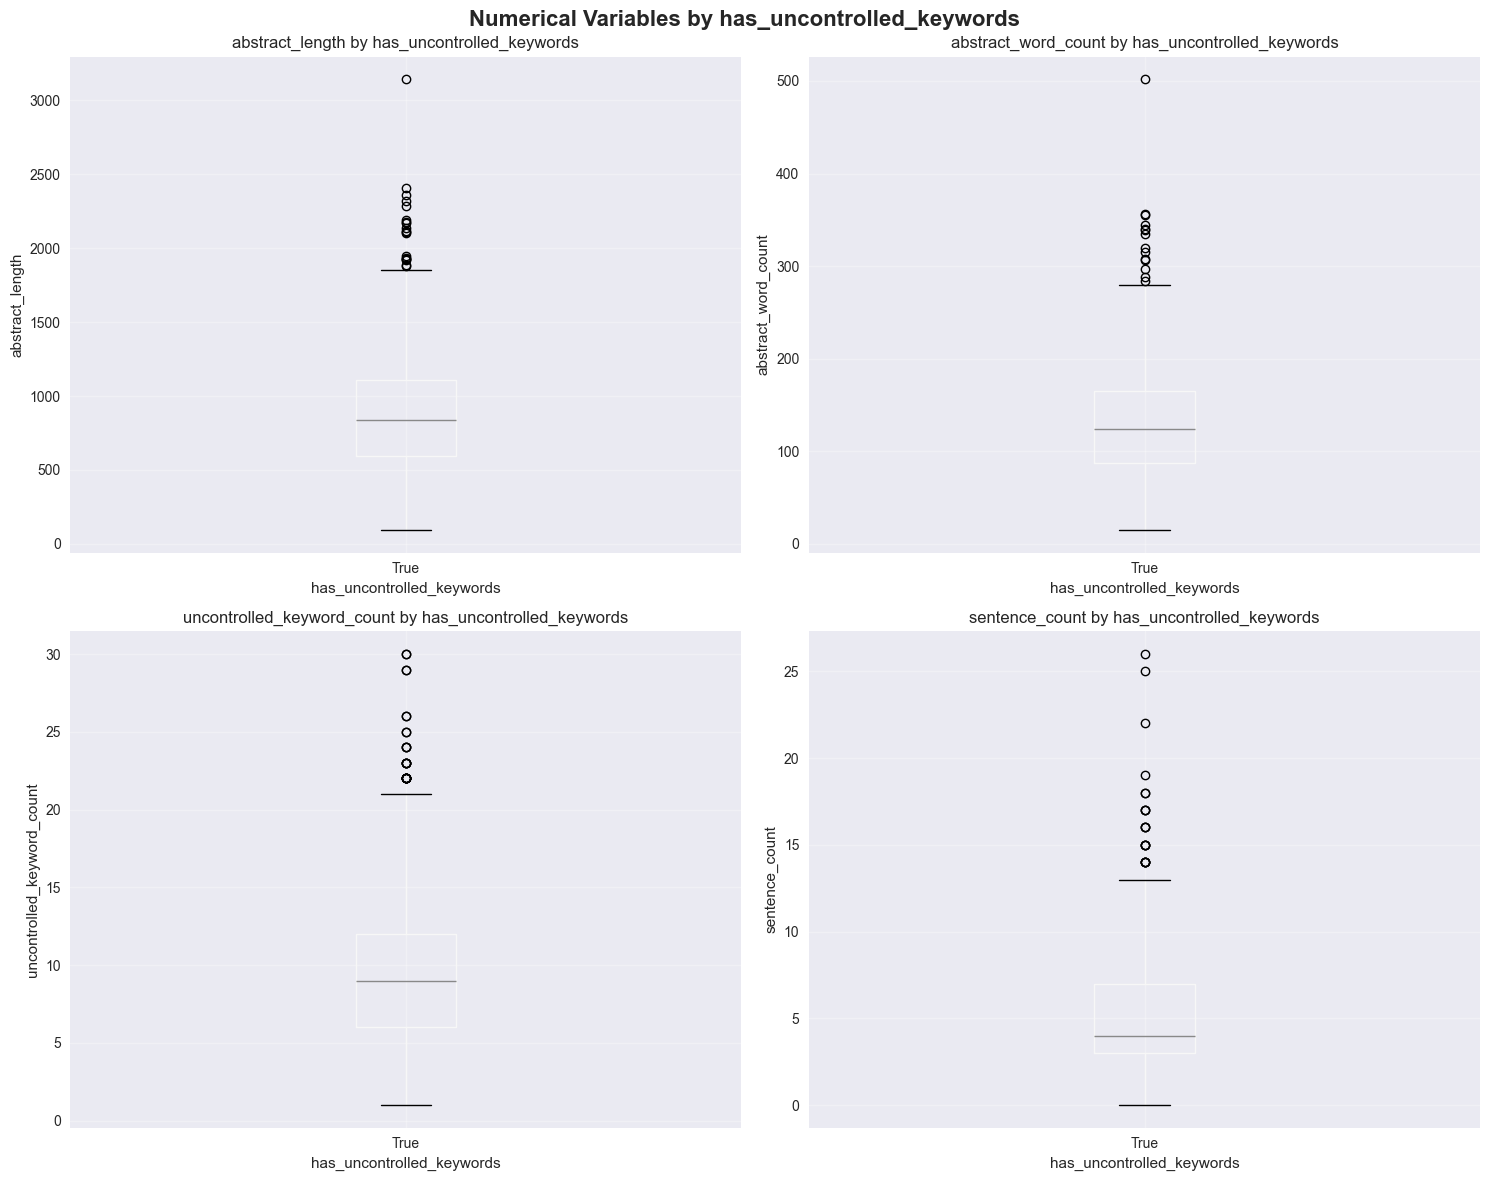


Statistical summary by has_uncontrolled_keywords:

abstract_length:
                           count    mean  median     std
has_uncontrolled_keywords                               
True                        1000  869.54   839.0  415.59

abstract_word_count:
                           count   mean  median   std
has_uncontrolled_keywords                            
True                        1000  128.1   124.0  61.5

uncontrolled_keyword_count:
                           count  mean  median   std
has_uncontrolled_keywords                           
True                        1000  9.79     9.0  4.88

sentence_count:
                           count  mean  median   std
has_uncontrolled_keywords                           
True                        1000  4.93     4.0  3.38


In [139]:
# Analyze categorical vs numerical relationships
categorical_vars = ['has_controlled_keywords', 'has_uncontrolled_keywords']
numerical_vars = ['abstract_length', 'abstract_word_count', 'uncontrolled_keyword_count', 'sentence_count']

for cat_var in categorical_vars:
    if cat_var in df_features.columns:
        print(f"\nAnalysis of {cat_var} vs Numerical Variables")
        print("=" * 60)
        
        # Create grouped box plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.ravel()
        
        for i, num_var in enumerate(numerical_vars):
            if num_var in df_features.columns and i < len(axes):
                df_features.boxplot(column=num_var, by=cat_var, ax=axes[i])
                axes[i].set_title(f'{num_var} by {cat_var}')
                axes[i].set_xlabel(cat_var)
                axes[i].set_ylabel(num_var)
                axes[i].grid(True, alpha=0.3)
        
        # Hide unused subplots
        for i in range(len(numerical_vars), len(axes)):
            axes[i].set_visible(False)
        
        plt.suptitle(f'Numerical Variables by {cat_var}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Statistical summary by category
        print(f"\nStatistical summary by {cat_var}:")
        for num_var in numerical_vars:
            if num_var in df_features.columns:
                print(f"\n{num_var}:")
                grouped_stats = df_features.groupby(cat_var)[num_var].agg(['count', 'mean', 'median', 'std'])
                print(grouped_stats.round(2))


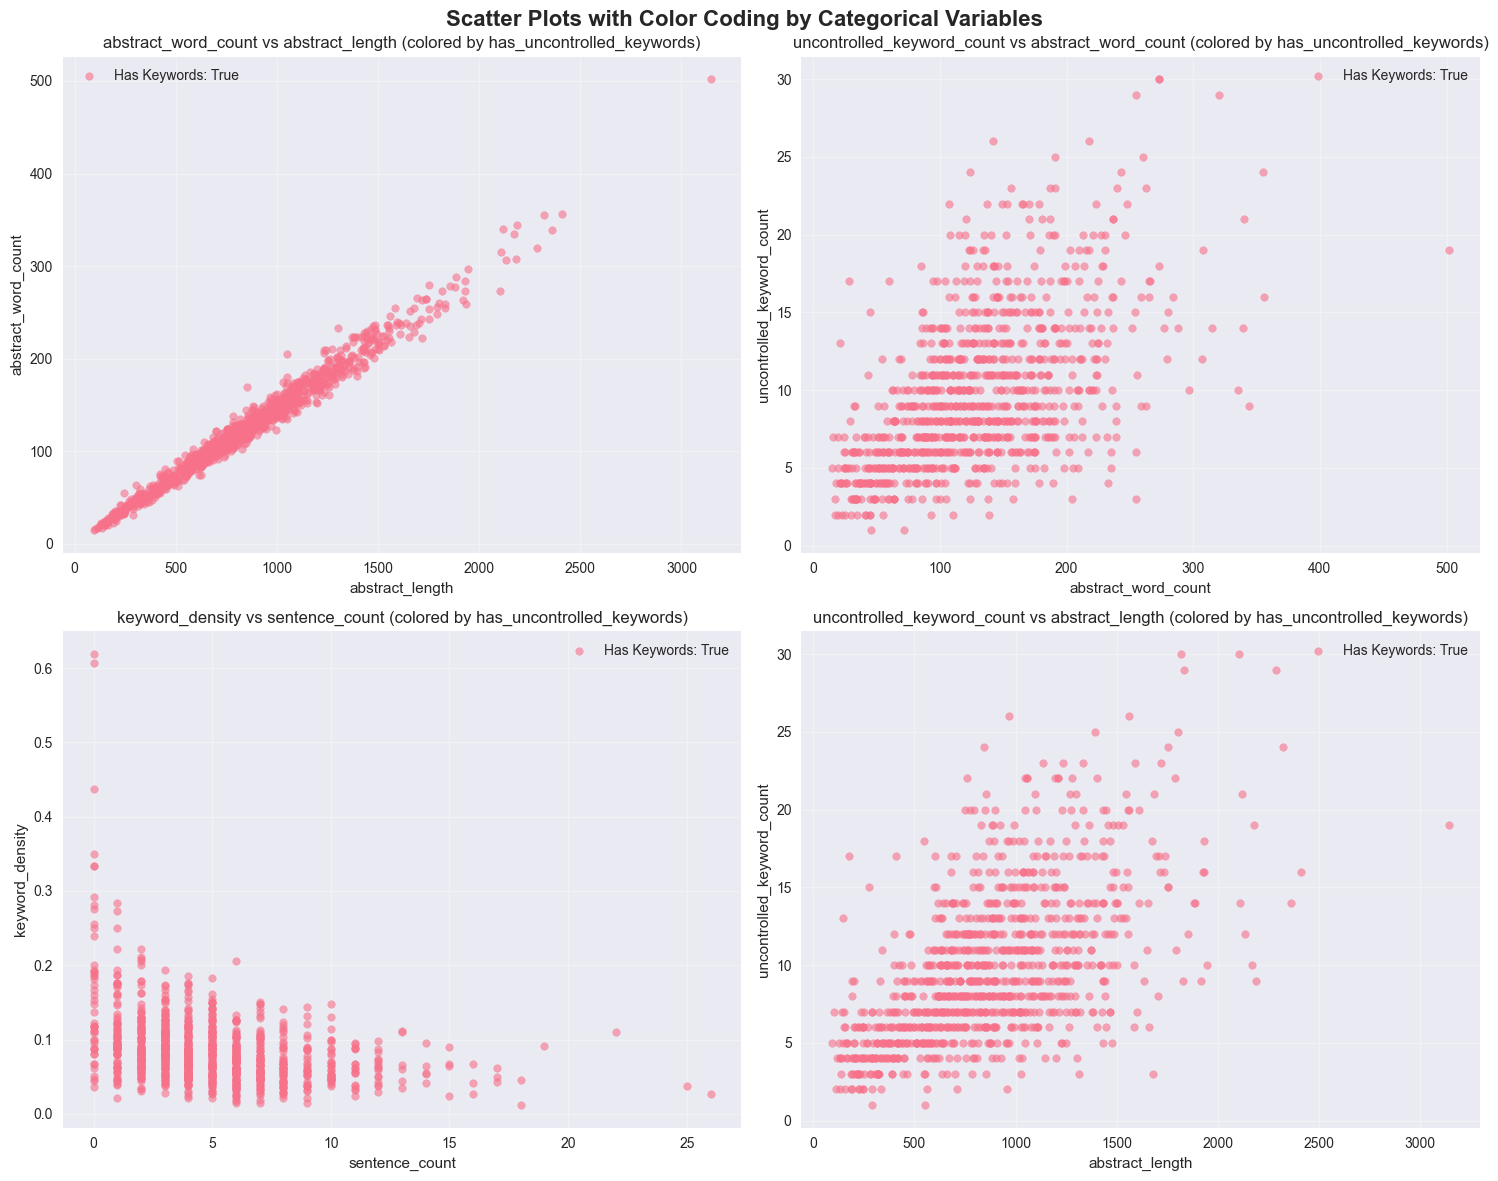

In [140]:
# Create scatter plots with color coding
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (x_var, y_var) in enumerate([('abstract_length', 'abstract_word_count'), 
                                   ('abstract_word_count', 'uncontrolled_keyword_count'),
                                   ('sentence_count', 'keyword_density'),
                                   ('abstract_length', 'uncontrolled_keyword_count')]):
    if x_var in df_features.columns and y_var in df_features.columns and i < len(axes):
        for category in df_features['has_uncontrolled_keywords'].unique():
            mask = df_features['has_uncontrolled_keywords'] == category
            axes[i].scatter(df_features.loc[mask, x_var], df_features.loc[mask, y_var], 
                          alpha=0.6, label=f'Has Keywords: {category}', s=30)
        
        axes[i].set_xlabel(x_var)
        axes[i].set_ylabel(y_var)
        axes[i].set_title(f'{y_var} vs {x_var} (colored by has_uncontrolled_keywords)')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.suptitle('Scatter Plots with Color Coding by Categorical Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
